In [6]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow

In [7]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from scipy.ndimage import zoom
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage.transform import resize, rotate
import random
import IPython

# Load LIDC dataset
### Step 1: Load all nodules as a 3D representation in numpy array & the labels from the nodule name

In [8]:
# Select an even number of slices to extract:
num_slices = 6
# Select nodules dataset location
lidc_path = Path('F:\\master\\manifest-1600709154662\\nodules_16slices')

In [9]:
images = []
diagnostics = []
nodules_path = list(lidc_path.iterdir())
for nodule_path in nodules_path:
    images_path = list(nodule_path.iterdir())
    # Reduce the slices to the specified amount:
    images_path = images_path[int(len(images_path)/2)-int(num_slices/2):int(len(images_path)/2)+int(num_slices/2)]
    # Merge all slices of a nodule together --> create 3D representation of the nodule
    image_nodule = []
    for image_path in images_path:
        # Load slice image
        image_slice = np.array(Image.open(image_path)) / 255.0
        # Add it to the nodule
        image_nodule.append(image_slice)
    # convert the 3D nodule to numpy array
    image_nodule = np.array(image_nodule)
    
    diag = int(nodule_path.name.split('_')[5])
    # remove incorrect image shape or diagnostic incogruent
    if image_nodule.shape == (num_slices, 64, 64) and diag != 3:
        # Add the nodule 3D representation to the list of images
        images.append(image_nodule)
        # Save nodule label (diagnostic)
        diagnostics.append(diag)
    elif image_nodule.shape != (num_slices, 64, 64):
        print(f'[ERROR] {nodule_path.name} has shape {image_nodule.shape}, but expected shape is: (16, 64, 64)')
# convert the dataset to numpy array
images = np.array(images)

[ERROR] patient_462_nod_1_diag_2 has shape (6, 64, 54), but expected shape is: (16, 64, 64)
[ERROR] patient_463_nod_1_diag_2 has shape (6, 64, 54), but expected shape is: (16, 64, 64)
[ERROR] patient_655_nod_3_diag_2 has shape (6, 64, 57), but expected shape is: (16, 64, 64)
[ERROR] patient_997_nod_2_diag_1 has shape (6, 64, 55), but expected shape is: (16, 64, 64)


#### Visualize data

In [10]:
from collections import Counter
import pandas

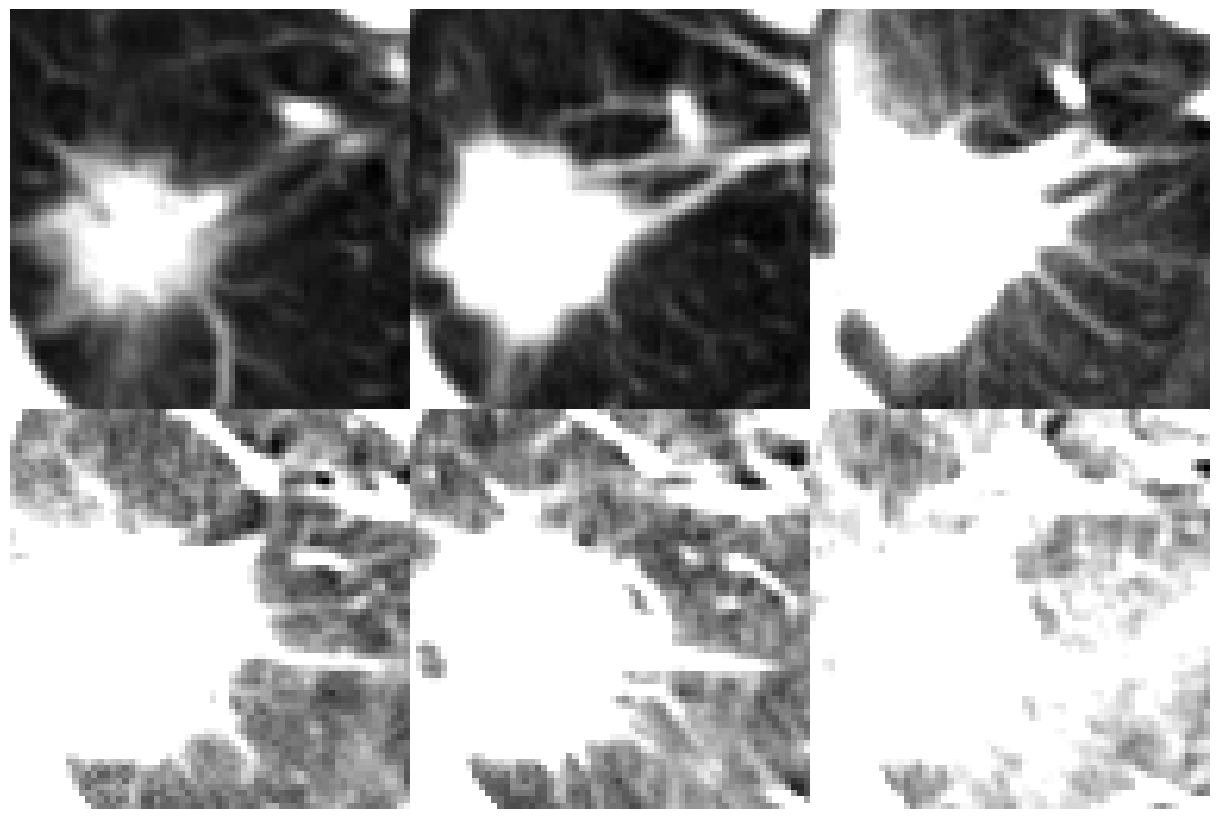

In [11]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of X CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i, j], cmap="gray")  # Corrected indexing
            #axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
plot_slices(
    num_rows=2, 
    num_columns=3, 
    width=64, 
    height=64, 
    data=images[0].transpose()
)

### Ste 2: Simplify labels
The label is a subjective assessment of the likelihood of malignancy of the given nodule, assuming the scan originated from a 60-year-old male smoker.

The original label system has 5 labels:

1: ‘Highly Unlikely’

2: ‘Moderately Unlikely’

3: ‘Indeterminate’

4: ‘Moderately Suspicious’

5: ‘Highly Suspicious’

It has been simplified to a binary clasification system, being:

0: if original label < 3 (benign)

1: if original label > 3 (malign)

In [12]:
# Simplify label system
labels = [0 if label<3 else 1 for label in diagnostics]
labels = np.array(labels)

<Axes: >

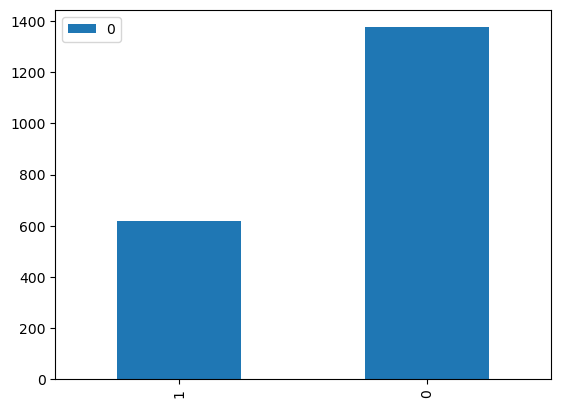

In [13]:
count = Counter(labels)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

# Data augmentation

In [14]:
def rotate_image(image):
    # define some rotation angles
    angles = [-20, -10, -5, 5, 10, 20]
    # pick angles at random
    angle = random.choice(angles)
    # rotate volume
    image = rotate(image.transpose(), angle).transpose()
    return image

In [15]:
images_aug = list(images)
labels_aug = list(labels)
for i, l in zip(images, labels):
    if l==1:
        images_aug.append(rotate_image(i))
        labels_aug.append(l)

images_aug = np.array(images_aug)
labels_aug = np.array(labels_aug)

<Axes: >

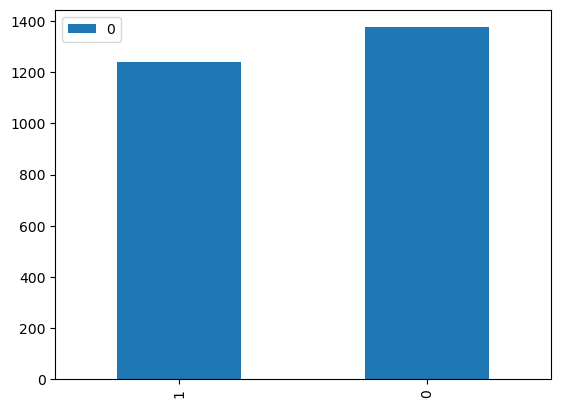

In [16]:
count = Counter(labels_aug)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

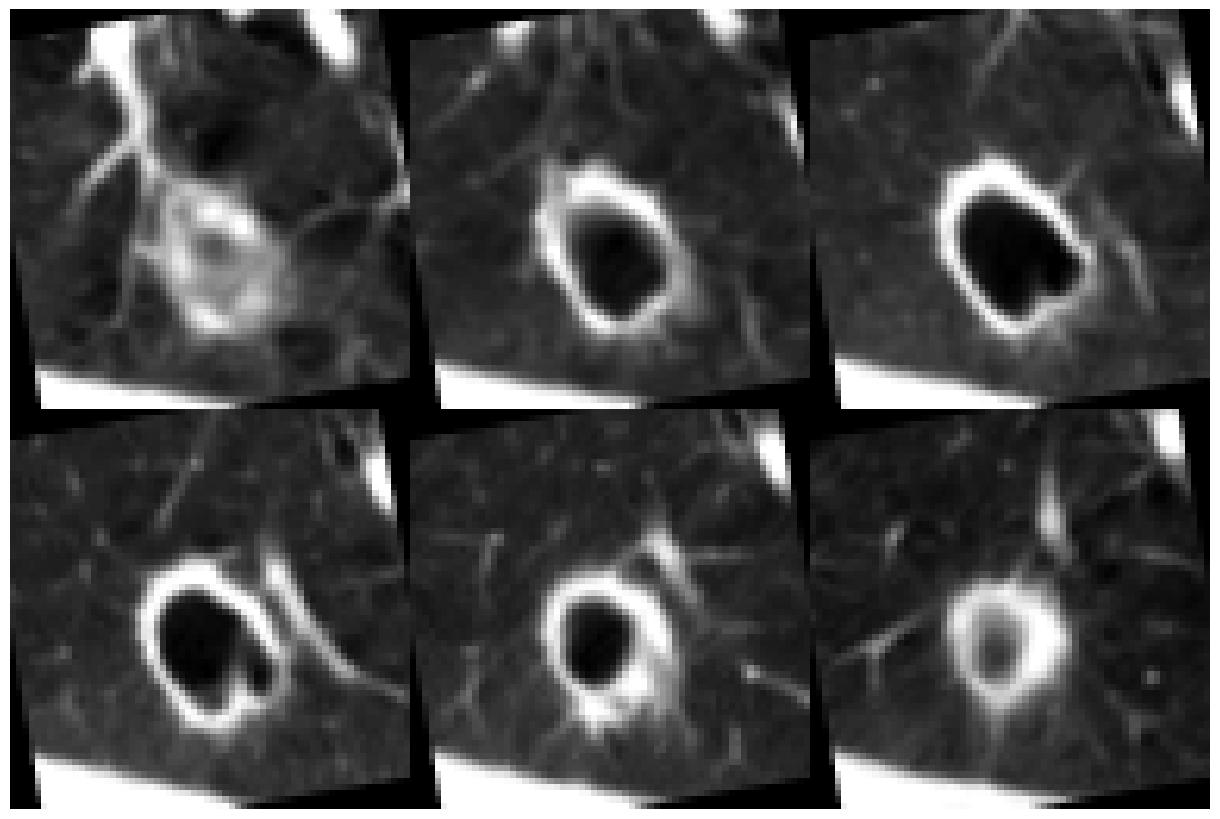

In [17]:
# Visualize montage of slices.
plot_slices(
    num_rows=2, 
    num_columns=3, 
    width=64, 
    height=64, 
    data=images_aug[-1].transpose()
)

Divide between train and test data

In [18]:
# Create train and test dataset
train_images, test_images, train_labels, test_labels = train_test_split(images_aug, labels_aug, test_size=0.33, random_state=42)

# Building the CNN:
Models used by others: https://github.com/marichka-dobko/Lung_Nodule_Classification/blob/master/src_keras/models_keras.py

A simple CNN with 5 convolutional layers

In [19]:
def le_net_3d():
    model = keras.Sequential()
    model.add(layers.Convolution3D(6, kernel_size=(1, 5, 5), activation='relu', input_shape=(6,64,64,1)))
    model.add(layers.MaxPooling3D(strides=2)) 
    model.add(layers.Convolution3D(16, kernel_size=(1, 5, 5), activation='relu'))
    model.add(layers.MaxPooling3D(strides=2)) 

    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    return model

def get_model():    
    model = keras.Sequential()
    model.add(layers.Convolution3D(filters=8, kernel_size=(1, 5, 5), strides=1, activation='relu', input_shape=(6,64,64,1)))
    model.add(layers.MaxPooling3D(pool_size=(1, 2,2), strides=2))
    model.add(layers.Convolution3D(filters=16, kernel_size=(1, 5, 5),strides=1, activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(1, 2,2), strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=150, activation='relu'))
    model.add(layers.Dense(units=100, activation='relu'))
    model.add(layers.Dense(units=50, activation='relu'))
    model.add(layers.Dense(units=2, activation = 'softmax'))
    
    return model


# Build model.
model = le_net_3d()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 6, 60, 60, 6)      156       
                                                                 
 max_pooling3d (MaxPooling3  (None, 3, 30, 30, 6)      0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 26, 26, 16)     2416      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 13, 13, 16)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 2704)              0         
                                                                 
 dense (Dense)               (None, 120)               

In [20]:
def fit_model(model, epochs):  
    model.compile(  
        optimizer="adam",  
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
        metrics=["accuracy"],  
    )  

    model.fit(  
        train_images,  
        train_labels,  
        epochs=epochs,  
        validation_data=(test_images, test_labels),  
    )  
    return model  


model = fit_model(model, epochs=10)


Epoch 1/10



C:\Users\pau_a\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



55/55 [==============================] - 4s 51ms/step - loss: 0.6135 - accuracy: 0.6497 - val_loss: 0.5203 - val_accuracy: 0.7520
Epoch 2/10
55/55 [==============================] - 3s 46ms/step - loss: 0.4611 - accuracy: 0.7834 - val_loss: 0.4572 - val_accuracy: 0.7787
Epoch 3/10
55/55 [==============================] - 3s 46ms/step - loss: 0.3989 - accuracy: 0.8171 - val_loss: 0.4343 - val_accuracy: 0.8076
Epoch 4/10
55/55 [==============================] - 2s 44ms/step - loss: 0.3548 - accuracy: 0.8383 - val_loss: 0.4120 - val_accuracy: 0.7984
Epoch 5/10
55/55 [==============================] - 3s 45ms/step - loss: 0.3170 - accuracy: 0.8537 - val_loss: 0.4065 - val_accuracy: 0.8111
Epoch 6/10
55/55 [==============================] - 3s 46ms/step - loss: 0.2659 - accuracy: 0.8897 - val_loss: 0.4687 - val_accuracy: 0.8053
Epoch 7/10
55/55 [==============================] - 3s 50ms/step - loss: 0.2424 - accuracy: 0.8931 - val_loss: 0.4541 - val_accuracy: 0.8227
Epoch 8/10
55/55 [=====

# GRAD-CAM heatmap

In [164]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to shape"""
    # Rescale heatmap to a range 0-255
    upscaled_heatmap = np.uint8(255 * heatmap)

    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],
            shape[1] / upscaled_heatmap.shape[1],
            shape[2] / upscaled_heatmap.shape[2],
        ),
    )

    return upscaled_heatmap

def display_gradcam(img, heatmap, alpha=0.4, cam_path='cam.jpg'):
    img = keras.utils.img_to_array(img)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + np.uint8(255 * img)
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    
    # Save GRAND CAM
    superimposed_img.save(cam_path)
    # Display Grad CAM
    IPython.display.display(IPython.display.Image(cam_path, width=500))

def display_gradcam(img, heatmap, alpha=0.4):
    fig, ax = plt.subplots(1, 2, figsize=(10, 20))

    ax[0].imshow(np.squeeze(img), cmap='gray')
    img0 = ax[1].imshow(np.squeeze(img), cmap='gray')
    img1 = ax[1].imshow(np.squeeze(heatmap), cmap='jet', alpha=alpha, extent=img0.get_extent())
    plt.show()

In [168]:
def compute_gradcam(img, label, alpha=0.4):
    # Prepare image
    img_array = img
    #print(f'Original image shape: {img_array.shape}')
    img_array = np.expand_dims(img_array, -1)
    img_array = np.expand_dims(img_array, 0)
    #print(f'Reshaped image shape: {img_array.shape}')

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    softmax_predictions = tf.nn.softmax(model(np.expand_dims([img], -1)), axis=1)
    pred_conf = softmax_predictions[0].numpy().max()  
    pred_label = np.argmax(softmax_predictions[0]) 
    print(f'Prediction: {pred_label} - {round(pred_conf*100, 2)}%')
    print(f'Ground truth: {label}')

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv3d_1')

    # Resize headmap from convolution layer shape to original image shape
    heatmap_upscaled = get_resized_heatmap(heatmap, shape=test_images[10].shape)

    # Superpose heatmap to middle image
    img_plot = np.expand_dims(img, -1)
    #print(f'Image to plot shape: {img_plot.shape}')
    display_gradcam(img_plot[2, :, :], heatmap_upscaled[2, :, :], alpha=alpha)

# Adding Dropout

Let’s see what a slightly different model would predict on these images. We’ll now use MC dropout as our model. By sampling, we should be able to increase the models’ uncertainty compared to a standard NN. 

Let’s first define our model:

In [82]:
def get_dropout_model():    
    model = keras.Sequential()
    model.add(layers.Convolution3D(filters=8, kernel_size=(1, 5, 5), strides=1, activation='relu', input_shape=(6,64,64,1)))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling3D(pool_size=(1, 2,2), strides=2))
    model.add(layers.Convolution3D(filters=16, kernel_size=(1, 5, 5),strides=1, activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(1, 2,2), strides=2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=150, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=100, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=50, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=2, activation = 'softmax'))
    
    return model

def le_net_3d_dropout():
    model = keras.Sequential()
    model.add(layers.Convolution3D(6, kernel_size=(1, 5, 5), activation='relu', input_shape=(6,64,64,1)))
    
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling3D(strides=2)) 
    model.add(layers.Convolution3D(16, kernel_size=(1, 5, 5), activation='relu'))
    model.add(layers.MaxPooling3D(strides=2))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(84, activation='relu'))
    
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))

    return model

def chat_gpt_model():
    model = keras.Sequential()
    model.add(layers.Conv3D(32, kernel_size=(1, 3, 3), activation='relu', input_shape=(6, 64, 64, 1)))
    
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2)))
    model.add(layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling3D(pool_size=(1, 2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(84, activation='relu'))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    return model

Then let’s instantiate it:

In [83]:
dropout_model = le_net_3d_dropout()
dropout_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 6, 60, 60, 6)      156       
                                                                 
 dropout_10 (Dropout)        (None, 6, 60, 60, 6)      0         
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 3, 30, 30, 6)      0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 3, 26, 26, 16)     2416      
                                                                 
 max_pooling3d_13 (MaxPooli  (None, 1, 13, 13, 16)     0         
 ng3D)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 1, 13, 13, 16)    

In [109]:
dropout_model = fit_model(dropout_model, epochs=10)

Epoch 1/10
55/55 [==============================] - 7s 103ms/step - loss: 0.6563 - accuracy: 0.6137 - val_loss: 0.5672 - val_accuracy: 0.7219
Epoch 2/10
55/55 [==============================] - 6s 102ms/step - loss: 0.5143 - accuracy: 0.7383 - val_loss: 0.4953 - val_accuracy: 0.7752
Epoch 3/10
55/55 [==============================] - 5s 99ms/step - loss: 0.4625 - accuracy: 0.7800 - val_loss: 0.4753 - val_accuracy: 0.7764
Epoch 4/10
55/55 [==============================] - 5s 99ms/step - loss: 0.4383 - accuracy: 0.7920 - val_loss: 0.4479 - val_accuracy: 0.7879
Epoch 5/10
55/55 [==============================] - 5s 95ms/step - loss: 0.3834 - accuracy: 0.8206 - val_loss: 0.4033 - val_accuracy: 0.8158
Epoch 6/10
55/55 [==============================] - 5s 95ms/step - loss: 0.3559 - accuracy: 0.8320 - val_loss: 0.3772 - val_accuracy: 0.8239
Epoch 7/10
55/55 [==============================] - 6s 104ms/step - loss: 0.3210 - accuracy: 0.8566 - val_loss: 0.3755 - val_accuracy: 0.8297
Epoch 8/10

Our model with dropout will achieve a similar accuracy as our vanilla model. Let’s now run inference with dropout and plot the mean confidence score of MC dropout:

In [110]:
def predictions_dropout(imgs):
    predictions = np.array(  
        [  
            tf.nn.softmax(dropout_model(np.expand_dims(imgs, -1), training=True), axis=1)  
            for _ in range(100)  
        ]  
    )  
    predictions_mean = np.mean(predictions, axis=0)
    return predictions_mean

This again produces a figure showing the predicted labels and their associated confidence scores:

In [111]:
def plot_predictions_dropout(predictions, imgs):
    plt.figure(figsize=(10, 10))  
    bbox_dict = dict(fill=True, facecolor="white", alpha=0.5, edgecolor="white", linewidth=0)
    middle_slice = int(len(imgs[0])/2)
    for i in range(len(imgs)):  
        plt.subplot(5, 5, i + 1)  
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)  
        plt.imshow(imgs[i][middle_slice], cmap="gray")  
        prediction = predictions[i].max()  
        label = np.argmax(predictions[i])  
        plt.xlabel(f"{label} - {prediction:.2%}")  
        plt.text(0, 3, f" {i+1}", bbox=bbox_dict)
    plt.show()

In [ ]:
for column, row in zip([True, False, True], [False, True, True]):
    print(f'Ground truth is: {test_labels[10]}')
    imgs = get_imgs_prgs_rem(test_images[10], column, row)
    predictions_mean = predictions_dropout(imgs)
    plot_predictions_dropout(predictions_mean, imgs)

The highest confidence is when only the full nodule is visible and non-nodule parts are black.

When the nodule is deleted from the image the confidence is significantly decreased.

In [166]:
def compute_gradcam_dropout(img, label, alpha=0.4, disp_original=True):
    # Prepare image
    img_array = img
    #print(f'Original image shape: {img_array.shape}')
    img_array = np.expand_dims(img_array, -1)
    img_array = np.expand_dims(img_array, 0)
    #print(f'Reshaped image shape: {img_array.shape}')

    # Remove last layer's softmax
    dropout_model.layers[-1].activation = None

    # Print what the top predicted class is
    softmax_predictions_drop_out = predictions_dropout([img])
    #softmax_predictions = tf.nn.softmax(model(np.expand_dims([test_images[10]], -1)), axis=1)
    pred_conf = softmax_predictions_drop_out[0].max()  
    pred_label = np.argmax(softmax_predictions_drop_out[0]) 
    print(f'Prediction: {pred_label} - {round(pred_conf*100, 2)}%')
    print(f'Ground truth: {label}')

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, dropout_model, last_conv_layer_name='conv3d_13')

    # Resize headmap from convolution layer shape to original image shape
    heatmap_upscaled = get_resized_heatmap(heatmap, shape=img.shape)

    # Superpose heatmap to middle image
    img_plot = np.expand_dims(img, -1)
    #print(f'Image to plot shape: {img_plot.shape}')
    display_gradcam(img_plot[2, :, :], heatmap_upscaled[2, :, :], alpha=alpha)

################## Traditional CNN ##################
Prediction: 0 - 100.0%
Ground truth: 0


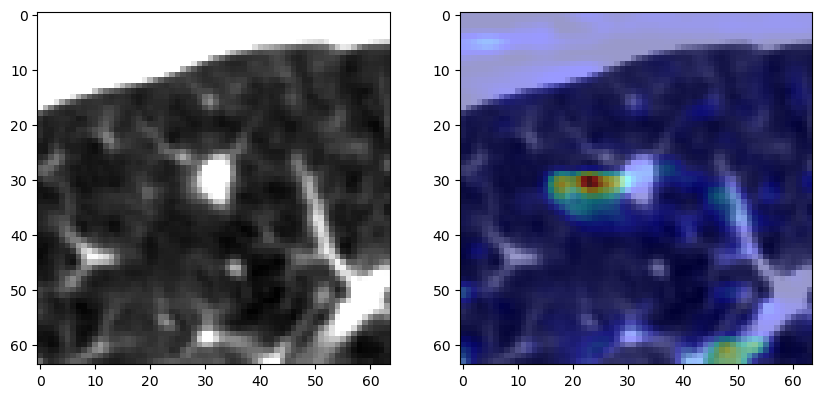

################## Dropout CNN ##################
Prediction: 0 - 99.72%
Ground truth: 0


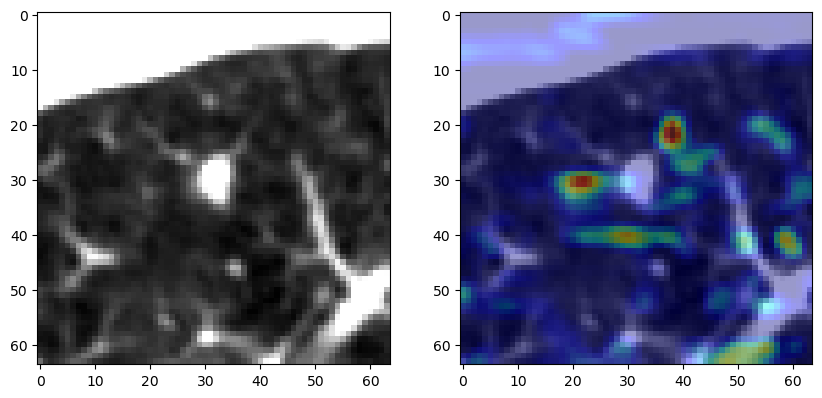

In [169]:
img_num = 1
print('################## Traditional CNN ##################')
compute_gradcam(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)
print('################## Dropout CNN ##################')
compute_gradcam_dropout(img=test_images[img_num], label=test_labels[img_num], alpha=0.4, disp_original=False)

################## Traditional CNN ##################
Prediction: 0 - 99.81%
Ground truth: 0


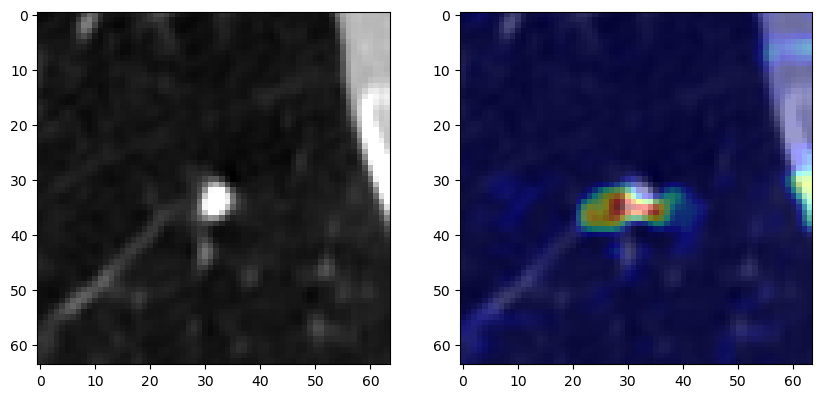

################## Dropout CNN ##################
Prediction: 0 - 97.14%
Ground truth: 0


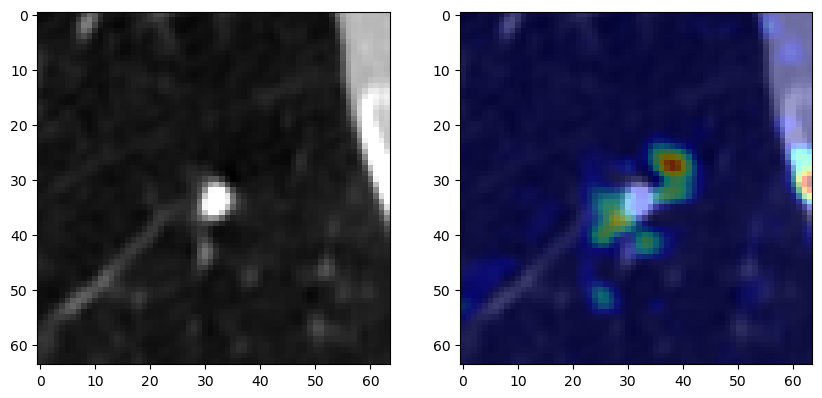

In [170]:
img_num = 10
print('################## Traditional CNN ##################')
compute_gradcam(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)
print('################## Dropout CNN ##################')
compute_gradcam_dropout(img=test_images[img_num], label=test_labels[img_num], alpha=0.4, disp_original=False)

################## Traditional CNN ##################
Prediction: 0 - 84.91%
Ground truth: 1


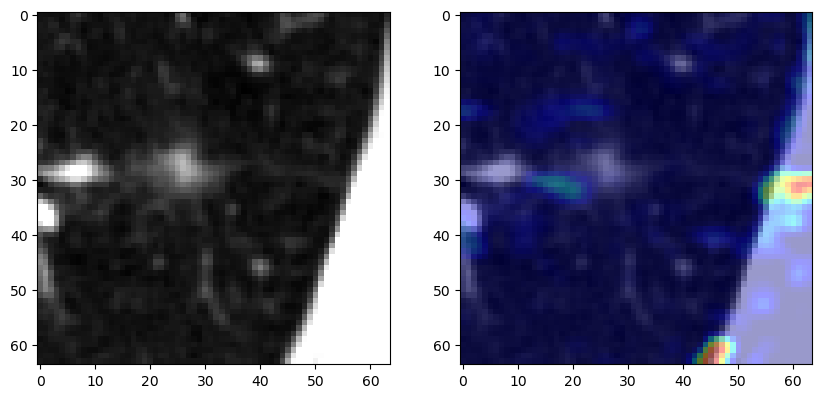

################## Dropout CNN ##################
Prediction: 0 - 66.1%
Ground truth: 1


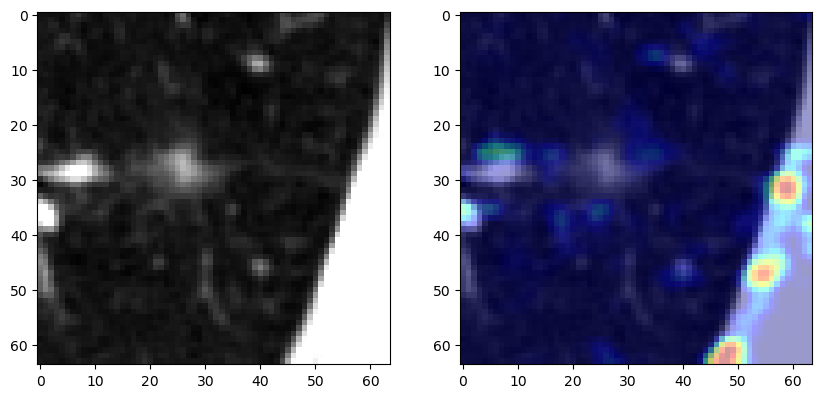

In [171]:
img_num = 13
print('################## Traditional CNN ##################')
compute_gradcam(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)
print('################## Dropout CNN ##################')
compute_gradcam_dropout(img=test_images[img_num], label=test_labels[img_num], alpha=0.4, disp_original=False)

################## Traditional CNN ##################
Prediction: 1 - 100.0%
Ground truth: 1


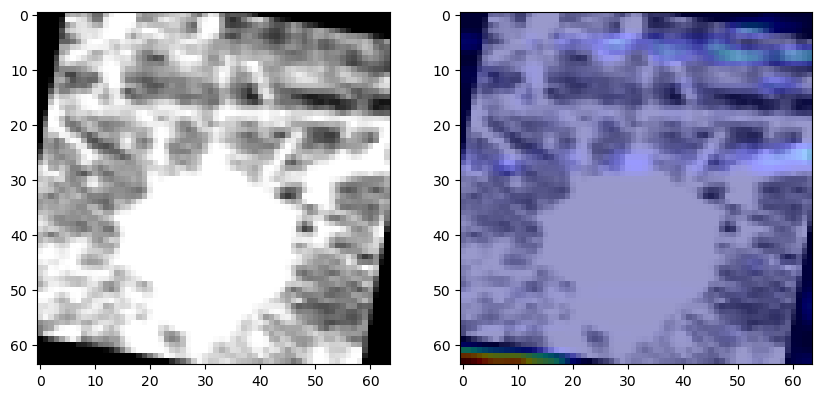

################## Dropout CNN ##################
Prediction: 1 - 99.97%
Ground truth: 1


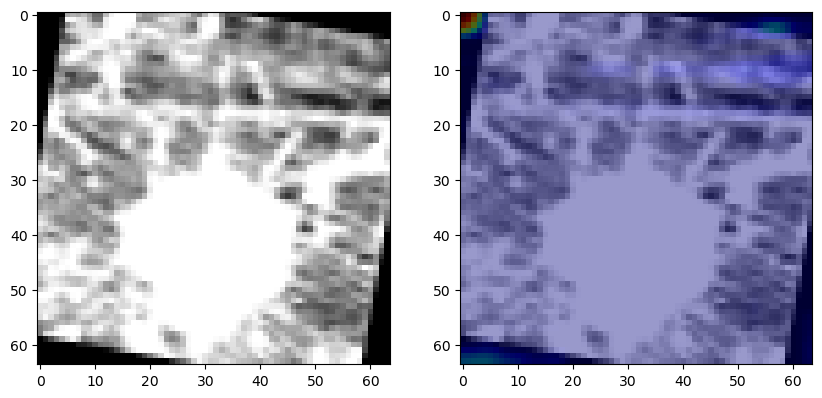

In [175]:
img_num = 22
print('################## Traditional CNN ##################')
compute_gradcam(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)
print('################## Dropout CNN ##################')
compute_gradcam_dropout(img=test_images[img_num], label=test_labels[img_num], alpha=0.4, disp_original=False)

################## Traditional CNN ##################
Prediction: 0 - 99.72%
Ground truth: 0


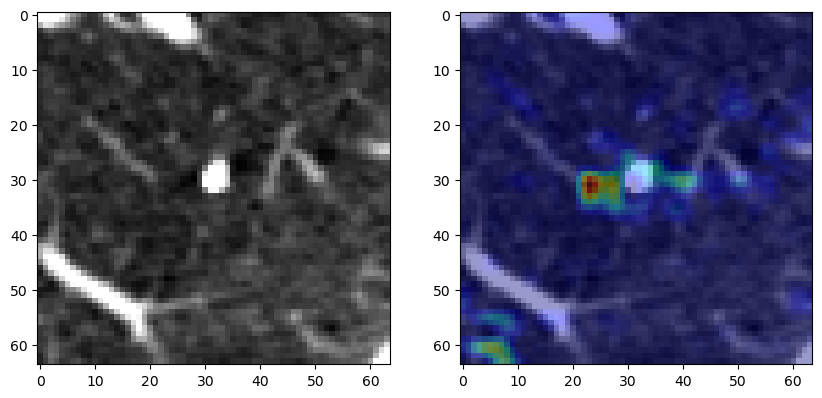

################## Dropout CNN ##################
Prediction: 0 - 99.21%
Ground truth: 0


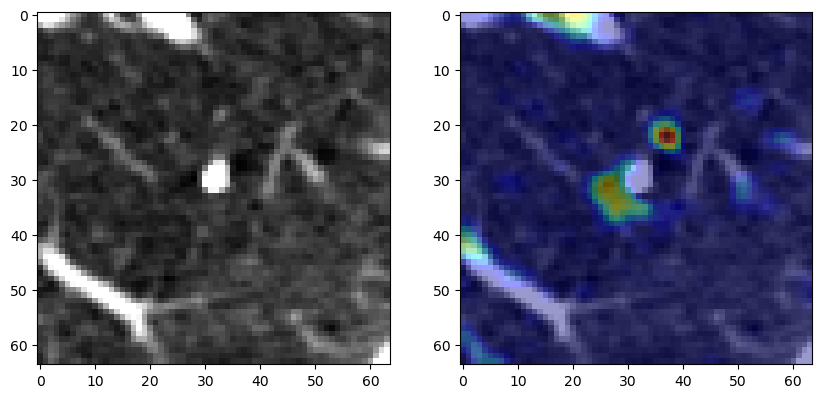

In [177]:
img_num = 23
print('################## Traditional CNN ##################')
compute_gradcam(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)
print('################## Dropout CNN ##################')
compute_gradcam_dropout(img=test_images[img_num], label=test_labels[img_num], alpha=0.4, disp_original=False)

# Next step

It is concluded that since all the rotated images are from class 1 (50% of class 1 images), the algorithm learned that a rotated image = class 1 image.

Therefore, is needed to create also rotated images in class 0